

### В этом ноутбуке мы построим модель классификации текстов на основе LSTM-сетей с использованием PyTorch. 
### Датасет содержит статьи на английском языке из 5 тематических классов. Цель — достичь максимально возможного качества классификации.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from collections import Counter
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import warnings

from src.logger import logger

warnings.filterwarnings('ignore')

2026-01-11 12:31:40.031929: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/i.danilov/sandbox/nn_labs/venv/lib/python3.11/site-packages/keras/src/export/tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


### Загрузим словари nltk

In [2]:
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')
    
try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')

try:
    nltk.data.find('punkt_tab')
except LookupError:
    nltk.download('punkt_tab')



[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/i.danilov/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


### Загрузим датасет

In [3]:
df = pd.read_csv('labs_data/lab3_5/Documents topics (Politics 0, Sport 1, Technology 2, Entertainment 3, Business 4).csv')
df = df.dropna()
df

,token,label
0,Budget to set scene for election\n \n Gordon B...,0
1,Army chiefs in regiments decision\n \n Militar...,0
2,Howard denies split over ID cards\n \n Michael...,0
3,Observers to monitor UK election\n \n Minister...,0
4,Kilroy names election seat target\n \n Ex-chat...,0
...,...,...
2220,India opens skies to competition\n \n India wi...,4
2221,Yukos bankruptcy 'not US matter'\n \n Russian ...,4
2222,Survey confirms property slowdown\n \n Governm...,4
2223,High fuel prices hit BA's profits\n \n British...,4


### Посмотрим на распределение классов

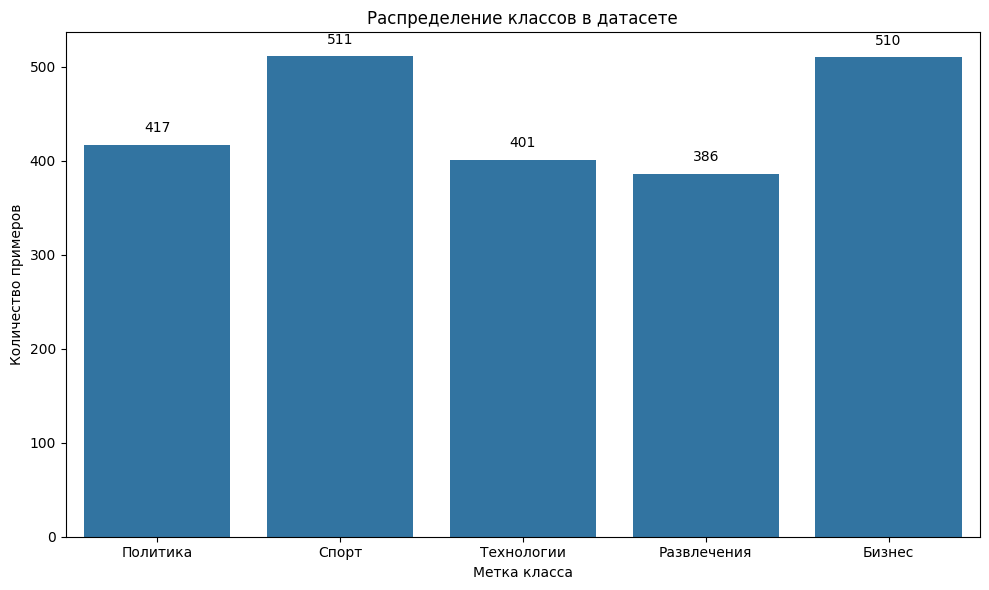

2026-01-11 12:31:41,804 - src.logger - 26 - INFO - 
Анализ дисбаланса классов:
2026-01-11 12:31:41,805 - src.logger - 30 - INFO - Коэффициент дисбаланса (наибольший/наименьший): 1.32


In [4]:
def get_class_name(label):
    class_names = {
        0: 'Политика',
        1: 'Спорт',
        2: 'Технологии',
        3: 'Развлечения',
        4: 'Бизнес'
    }
    return class_names.get(label, f'Неизвестный класс {label}')

class_counts = df['label'].value_counts().sort_index()

plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='label')
plt.title('Распределение классов в датасете')
plt.xlabel('Метка класса')
plt.ylabel('Количество примеров')

for i, v in enumerate(class_counts.values):
    plt.text(i, v + 10, str(v), ha='center', va='bottom')
    
plt.xticks(ticks=range(5), labels=[get_class_name(i) for i in range(5)])
plt.tight_layout()
plt.show()

logger.info('\nАнализ дисбаланса классов:')
max_class = max(class_counts)
min_class = min(class_counts)
imbalance_ratio = max_class / min_class
logger.info(f'Коэффициент дисбаланса (наибольший/наименьший): {imbalance_ratio:.2f}')



Проблемы дисбаланса не наблюдается

### Подготовим тексты - удалим специальные символы и цифры, токенизируем тексты, удалим стоп-слова из словаря nltk

In [5]:
def preprocess_text(text):
    text = text.lower()
    
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    tokens = word_tokenize(text)
    
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    
    processed_text = ' '.join(tokens)
    
    return processed_text

logger.info('Предобработка текстовых данных...')
df['processed_text'] = df['token'].apply(preprocess_text)

logger.info('\nПримеры оригинального и обработанного текста:')
for i in range(3):
    logger.info(f'Оригинал: {df.iloc[i]["token"][:100]}...')
    logger.info(f'Обработано: {df.iloc[i]["processed_text"][:100]}...')

2026-01-11 12:31:41,812 - src.logger - 15 - INFO - Предобработка текстовых данных...
2026-01-11 12:31:43,321 - src.logger - 18 - INFO - 
Примеры оригинального и обработанного текста:
2026-01-11 12:31:43,322 - src.logger - 20 - INFO - Оригинал: Budget to set scene for election
 
 Gordon Brown will seek to put the economy at the centre of Labou...
2026-01-11 12:31:43,322 - src.logger - 21 - INFO - Обработано: budget set scene election gordon brown seek put economy centre labours bid third term power delivers...
2026-01-11 12:31:43,322 - src.logger - 20 - INFO - Оригинал: Army chiefs in regiments decision
 
 Military chiefs are expected to meet to make a final decision o...
2026-01-11 12:31:43,323 - src.logger - 21 - INFO - Обработано: army chiefs regiments decision military chiefs expected meet make final decision future scotlands ar...
2026-01-11 12:31:43,323 - src.logger - 20 - INFO - Оригинал: Howard denies split over ID cards
 
 Michael Howard has denied his shadow cabinet was split 

Максимальная длина последовательности (95-й перцентиль): 402


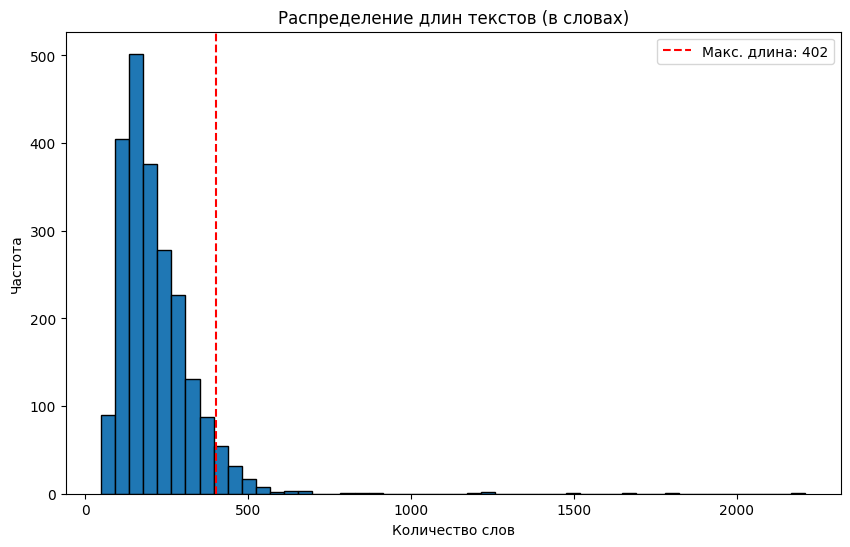

In [6]:
text_lengths = [len(text.split()) for text in df['processed_text']]
max_length = int(np.percentile(text_lengths, 95)) 
print(f'Максимальная длина последовательности (95-й перцентиль): {max_length}')

plt.figure(figsize=(10, 6))
plt.hist(text_lengths, bins=50, edgecolor='black')
plt.axvline(max_length, color='red', linestyle='--', label=f'Макс. длина: {max_length}')
plt.title('Распределение длин текстов (в словах)')
plt.xlabel('Количество слов')
plt.ylabel('Частота')
plt.legend()
plt.show()

##### Видим, что есть тексты больше 512 токенов - но их незначительно мало, так что не будет страшно их обрезать при использовании предобученной модели-эмбеддера из КР intfloat/multilingual-e5-base

### Обучим токенизатор и токенизируем данные

In [7]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['processed_text'])

vocab_size = len(tokenizer.word_index) + 1
logger.info(f'Размер словаря: {vocab_size}')

sequences = tokenizer.texts_to_sequences(df['processed_text'])
X = pad_sequences(sequences, maxlen=max_length, padding='post', truncating='post')
y = df['label'].values

logger.info(f'Размер входных данных: {X.shape}')
logger.info(f'Размер меток: {y.shape}')

2026-01-11 12:31:43,634 - src.logger - 5 - INFO - Размер словаря: 31404
2026-01-11 12:31:43,729 - src.logger - 11 - INFO - Размер входных данных: (2225, 402)
2026-01-11 12:31:43,729 - src.logger - 12 - INFO - Размер меток: (2225,)


### Разделим выборки на train, val, test

In [8]:
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp)

logger.info(f'Обучающая выборка: {X_train.shape[0]} примеров')
logger.info(f'Валидационная выборка: {X_val.shape[0]} примеров')
logger.info(f'Тестовая выборка: {X_test.shape[0]} примеров')

2026-01-11 12:31:43,741 - src.logger - 4 - INFO - Обучающая выборка: 1335 примеров
2026-01-11 12:31:43,742 - src.logger - 5 - INFO - Валидационная выборка: 445 примеров
2026-01-11 12:31:43,742 - src.logger - 6 - INFO - Тестовая выборка: 445 примеров


### Создадим датасеты

In [9]:
class TextDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = torch.tensor(texts, dtype=torch.long)
        self.labels = torch.tensor(labels, dtype=torch.long)
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        return self.texts[idx], self.labels[idx]
    
batch_size = 32
train_dataset = TextDataset(X_train, y_train)
val_dataset = TextDataset(X_val, y_val)
test_dataset = TextDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

### Создаим двунаправленную модель на базе LSTM ячеек

In [10]:
class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_classes, num_layers=2, dropout=0.3):
        super(LSTMClassifier, self).__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(
            embedding_dim, 
            hidden_dim, 
            num_layers=num_layers, 
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0,
            bidirectional=True
        )
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim * 2, num_classes)  # *2 из-за двунаправленности
        
    def forward(self, x):
        embedded = self.embedding(x)
        lstm_out, (hidden, _) = self.lstm(embedded)
        
        hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)
        
        output = self.dropout(hidden)
        output = self.fc(output)
        
        return output
    
embedding_dim = 768
hidden_dim = 768
num_classes = 5
num_layers = 2
dropout = 0.1

model = LSTMClassifier(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    hidden_dim=hidden_dim,
    num_classes=num_classes,
    num_layers=num_layers,
    dropout=dropout
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

logger.info(model)
logger.info(f'Количество параметров модели: {sum(p.numel() for p in model.parameters()):,}')

2026-01-11 12:31:44,143 - src.logger - 46 - INFO - LSTMClassifier(
  (embedding): Embedding(31404, 768)
  (lstm): LSTM(768, 768, num_layers=2, batch_first=True, dropout=0.1, bidirectional=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (fc): Linear(in_features=1536, out_features=5, bias=True)
)
2026-01-11 12:31:44,143 - src.logger - 47 - INFO - Количество параметров модели: 47,743,493


### Обучим модель с начальными параметрами

In [11]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=20):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    
    best_val_loss = float('inf')
    best_model_state = None
    patience_counter = 0
    patience = 5
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        
        for texts, labels in train_loader:
            texts, labels = texts.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(texts)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
        
        epoch_train_loss = running_loss / len(train_loader)
        epoch_train_acc = 100 * correct_train / total_train
        
        model.eval()
        val_running_loss = 0.0
        correct_val = 0
        total_val = 0
        
        with torch.no_grad():
            for texts, labels in val_loader:
                texts, labels = texts.to(device), labels.to(device)
                outputs = model(texts)
                loss = criterion(outputs, labels)
                
                val_running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()
        
        epoch_val_loss = val_running_loss / len(val_loader)
        epoch_val_acc = 100 * correct_val / total_val
        
        train_losses.append(epoch_train_loss)
        val_losses.append(epoch_val_loss)
        train_accuracies.append(epoch_train_acc)
        val_accuracies.append(epoch_val_acc)
        
        scheduler.step(epoch_val_loss)
        
        logger.info(f'Эпоха [{epoch+1}/{num_epochs}]')
        logger.info(f'  Потери (обучение): {epoch_train_loss:.4f}, Точность (обучение): {epoch_train_acc:.2f}%')
        logger.info(f'  Потери (валидация): {epoch_val_loss:.4f}, Точность (валидация): {epoch_val_acc:.2f}%')
        
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            best_model_state = model.state_dict().copy()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                logger.info(f'Ранняя остановка на эпохе {epoch+1}')
                break
    
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
    
    return train_losses, val_losses, train_accuracies, val_accuracies

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=3e-5, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)

logger.info('Начало обучения...')
train_losses, val_losses, train_accuracies, val_accuracies = train_model(
    model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=30
)

2026-01-11 12:31:45,041 - src.logger - 84 - INFO - Начало обучения...
2026-01-11 12:31:55,793 - src.logger - 61 - INFO - Эпоха [1/30]
2026-01-11 12:31:55,795 - src.logger - 62 - INFO -   Потери (обучение): 1.5986, Точность (обучение): 22.85%
2026-01-11 12:31:55,795 - src.logger - 63 - INFO -   Потери (валидация): 1.5839, Точность (валидация): 27.64%
2026-01-11 12:32:06,320 - src.logger - 61 - INFO - Эпоха [2/30]
2026-01-11 12:32:06,322 - src.logger - 62 - INFO -   Потери (обучение): 1.5637, Точность (обучение): 32.66%
2026-01-11 12:32:06,322 - src.logger - 63 - INFO -   Потери (валидация): 1.5610, Точность (валидация): 27.64%
2026-01-11 12:32:16,866 - src.logger - 61 - INFO - Эпоха [3/30]
2026-01-11 12:32:16,867 - src.logger - 62 - INFO -   Потери (обучение): 1.5101, Точность (обучение): 40.90%
2026-01-11 12:32:16,867 - src.logger - 63 - INFO -   Потери (валидация): 1.5089, Точность (валидация): 49.89%
2026-01-11 12:32:27,494 - src.logger - 61 - INFO - Эпоха [4/30]
2026-01-11 12:32:27,

### Посмотрим графики

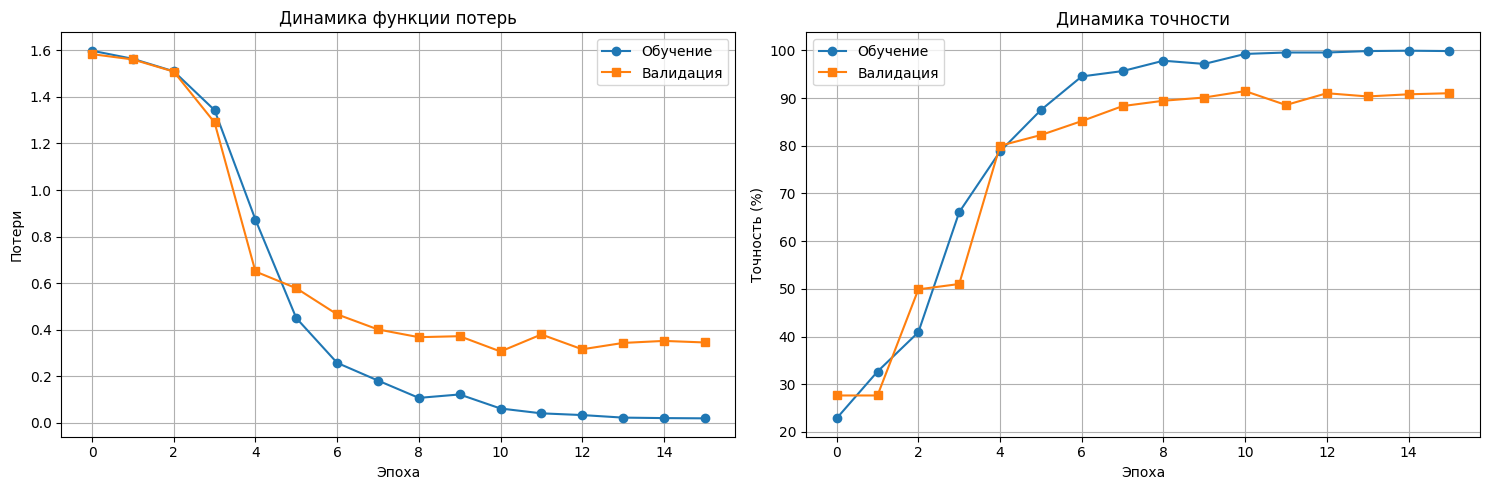

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(train_losses, label='Обучение', marker='o')
ax1.plot(val_losses, label='Валидация', marker='s')
ax1.set_title('Динамика функции потерь')
ax1.set_xlabel('Эпоха')
ax1.set_ylabel('Потери')
ax1.legend()
ax1.grid(True)

ax2.plot(train_accuracies, label='Обучение', marker='o')
ax2.plot(val_accuracies, label='Валидация', marker='s')
ax2.set_title('Динамика точности')
ax2.set_xlabel('Эпоха')
ax2.set_ylabel('Точность (%)')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

### Оценим модель на тесте

In [13]:
def evaluate_model(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for texts, labels in test_loader:
            texts, labels = texts.to(device), labels.to(device)
            outputs = model(texts)
            _, predicted = torch.max(outputs, 1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    return np.array(all_preds), np.array(all_labels)

test_preds, test_labels = evaluate_model(model, test_loader)

test_accuracy = accuracy_score(test_labels, test_preds)
logger.info(f'Точность на тестовой выборке: {test_accuracy:.4f}')

class_names = [get_class_name(i) for i in range(5)]
logger.info('\nОтчёт по классификации:')
print(classification_report(test_labels, test_preds, target_names=class_names))

2026-01-11 12:34:38,694 - src.logger - 20 - INFO - Точность на тестовой выборке: 0.8966
2026-01-11 12:34:38,694 - src.logger - 23 - INFO - 
Отчёт по классификации:


              precision    recall  f1-score   support

    Политика       0.93      0.85      0.89        84
       Спорт       0.86      0.98      0.92       102
  Технологии       0.87      0.86      0.87        80
 Развлечения       0.96      0.87      0.91        77
      Бизнес       0.88      0.90      0.89       102

    accuracy                           0.90       445
   macro avg       0.90      0.89      0.90       445
weighted avg       0.90      0.90      0.90       445



### Посмотрим матрицу ошибок

<!-- # Посмотрим матрицу ошибок -->

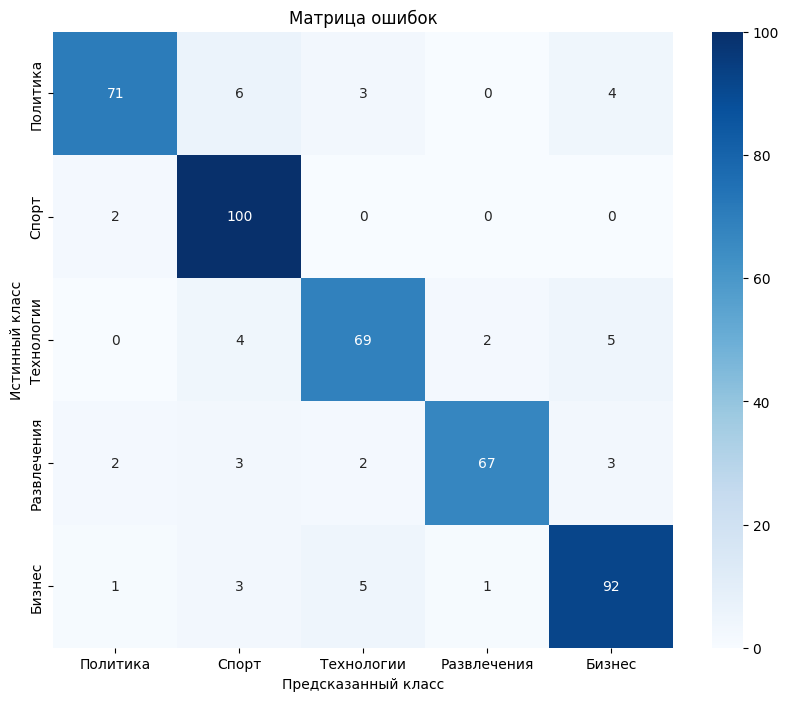

In [14]:
cm = confusion_matrix(test_labels, test_preds)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title('Матрица ошибок')
plt.xlabel('Предсказанный класс')
plt.ylabel('Истинный класс')
plt.show()

### Как подбирались гиперпараметры

In [18]:
def predict_text(text, model, tokenizer, max_length):
    processed_text = preprocess_text(text)
    
    sequence = tokenizer.texts_to_sequences([processed_text])
    padded_sequence = pad_sequences(sequence, maxlen=max_length, padding='post', truncating='post')
    tensor = torch.tensor(padded_sequence, dtype=torch.long).to(device)
    
    model.eval()
    with torch.no_grad():
        output = model(tensor)
        probabilities = torch.softmax(output, dim=1)
        predicted_class = torch.argmax(output, dim=1).item()
        confidence = probabilities[0][predicted_class].item()
    
    return predicted_class, confidence

def hyperparameter_tuning():
    hyperparams = [
        {'embedding_dim': 100, 'hidden_dim': 64, 'num_layers': 1, 'dropout': 0.2},
        {'embedding_dim': 100, 'hidden_dim': 128, 'num_layers': 2, 'dropout': 0.3},
        {'embedding_dim': 256, 'hidden_dim': 256, 'num_layers': 2, 'dropout': 0.3},
        {'embedding_dim': 512, 'hidden_dim': 512, 'num_layers': 1, 'dropout': 0.2},
        {'embedding_dim': 768, 'hidden_dim': 768, 'num_layers': 2, 'dropout': 0.1},
    ]
    
    results = []
    
    for i, params in enumerate(hyperparams):
        logger.info(f'\nТестируется комбинация гиперпараметров {i+1}: {params}')
        
        model = LSTMClassifier(
            vocab_size=vocab_size,
            embedding_dim=params['embedding_dim'],
            hidden_dim=params['hidden_dim'],
            num_classes=num_classes,
            num_layers=params['num_layers'],
            dropout=params['dropout']
        ).to(device)
        
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=3e-5, weight_decay=1e-5)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)
        
        train_losses, val_losses, train_accuracies, val_accuracies = train_model(
            model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=15
        )
        
        val_preds, val_labels = evaluate_model(model, val_loader)
        val_accuracy = accuracy_score(val_labels, val_preds)
        
        results.append({
            'params': params,
            'val_accuracy': val_accuracy,
            'final_val_loss': val_losses[-1] if val_losses else float('inf')
        })
        
        logger.info(f'Результат — точность на валидации: {val_accuracy:.4f}, потери: {val_losses[-1]:.4f}')
    
    best_result = max(results, key=lambda x: x['val_accuracy'])
    logger.info(f'\nЛучшие гиперпараметры: {best_result["params"]}')
    logger.info(f'Лучшая точность на валидации: {best_result["val_accuracy"]:.4f}')
    
    return results, best_result

results, best_result = hyperparameter_tuning()

2026-01-11 12:50:24,178 - src.logger - 29 - INFO - 
Тестируется комбинация гиперпараметров 1: {'embedding_dim': 100, 'hidden_dim': 64, 'num_layers': 1, 'dropout': 0.2}
2026-01-11 12:50:24,353 - src.logger - 61 - INFO - Эпоха [1/15]
2026-01-11 12:50:24,353 - src.logger - 62 - INFO -   Потери (обучение): 1.6104, Точность (обучение): 20.00%
2026-01-11 12:50:24,354 - src.logger - 63 - INFO -   Потери (валидация): 1.6032, Точность (валидация): 22.25%
2026-01-11 12:50:24,501 - src.logger - 61 - INFO - Эпоха [2/15]
2026-01-11 12:50:24,501 - src.logger - 62 - INFO -   Потери (обучение): 1.6013, Точность (обучение): 21.05%
2026-01-11 12:50:24,502 - src.logger - 63 - INFO -   Потери (валидация): 1.5996, Точность (валидация): 24.94%
2026-01-11 12:50:24,643 - src.logger - 61 - INFO - Эпоха [3/15]
2026-01-11 12:50:24,644 - src.logger - 62 - INFO -   Потери (обучение): 1.5992, Точность (обучение): 21.80%
2026-01-11 12:50:24,644 - src.logger - 63 - INFO -   Потери (валидация): 1.5972, Точность (валид

### Посмотрим на итоговые результаты лучшей модели

In [16]:
print('=== ИТОГИ ===')
print(f'Точность на тестовой выборке: {test_accuracy:.4f}')
print(f'Размер словаря: {vocab_size}')
print(f'Максимальная длина последовательности: {max_length}')
print(f'Архитектура модели: LSTM с {num_layers} слоями, {hidden_dim} скрытыми нейронами')
print(f'Размерность эмбеддингов: {embedding_dim}')
print(f'Вероятность dropout: {dropout}')

print('\n=== АНАЛИЗ ===')
if test_accuracy > 0.85:
    print('Модель достигла высокой точности (>85%), что указывает на хорошее качество')
else:
    print('Точность модели можно улучшить — рассмотрите дальнейшую оптимизацию')

=== ИТОГИ ===
Точность на тестовой выборке: 0.8966
Размер словаря: 31404
Максимальная длина последовательности: 402
Архитектура модели: LSTM с 2 слоями, 768 скрытыми нейронами
Размерность эмбеддингов: 768
Вероятность dropout: 0.1

=== АНАЛИЗ ===
Модель достигла высокой точности (>85%), что указывает на хорошее качество


### По итогам удалось подобрать оптимальные гиперпараметры модели для близкого к наилучшему возможному качеству классификации для данной аритектуры. Количество нейронов на входном и внутренних слоях совпали с головой классификатором в ЛР 5, однако, достичь качества как там не удалось, что подтверждает лучшую эффективность архитектуры трансформеров. Более старые архитектуры, однако, все еще можно использовать ввиду их отнсительной легкости для решения простых задач (как, например, в исследуемом датасете) 